## Comparison of the optimization algorithms

In [40]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.functional as F

print('torch version is {}'.format(torch.__version__))
if torch.cuda.is_available():
    print('cuda is available')
else:
    print('cuda is not available')

torch version is 1.10.0
cuda is available


In [41]:
# load MNIST data
train_Dataset = dsets.QMNIST(
      root='./data',  # rootで指定したフォルダーを作成して生データを展開
      train=True,  # 学習かテストかの選択
      transform=transforms.ToTensor(),  # PyTroch のテンソルに変換
      download=True)  # ダウンロードするかどうかの選択

test_dataset = dsets.QMNIST(
      root='./data',  
      train=False, 
      transform=transforms.ToTensor(),
      download=True)
print('train_Dataset = ', len(train_Dataset))

train_dataset, valid_dataset = torch.utils.data.random_split(  # データセットの分割
      train_Dataset,   # 分割するデータセット
      [50000, 10000])  # 分割数

print('train_dataset = ', len(train_dataset))
print('valid_dataset = ', len(valid_dataset))  
print('test_dataset = ', len(test_dataset))


train_Dataset =  60000
train_dataset =  50000
valid_dataset =  10000
test_dataset =  60000


In [42]:
# set data loader
batchsize = 128
train_loader = torch.utils.data.DataLoader(
      dataset=train_dataset,  # データセットの指定
      batch_size=batchsize,  # ミニバッチの指定
      shuffle=True,  # シャッフルするかどうかの指定
      num_workers=2)  # コアの数

valid_loader = torch.utils.data.DataLoader(
      dataset=valid_dataset,
      batch_size=batchsize, 
      shuffle=False,
      num_workers=2)

test_loader = torch.utils.data.DataLoader(
      dataset=test_dataset,
      batch_size=batchsize, 
      shuffle=False,
      num_workers=2)


In [43]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1,32,5, padding=1)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32,32,5, padding=1)
        self.pool2 = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(32*5*5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(F.gelu(self.conv1(x)))
        x = self.pool2(F.gelu(self.conv2(x)))
        x = x.view(-1, 32 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Network()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

if torch.cuda.is_available():
  net.cuda()

print('Network architecture for CNN\n', net)

cuda
Network architecture for CNN
 Network(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=800, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [44]:
# optimizing
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
#optimizer = optim.AdamW(net.parameters(), lr=0.01, weight_decay=0.01)


In [45]:
# Initialize Weights

#torch.cuda.manual_seed_all(100100)
#torch.manual_seed(100100)
#np.random.seed(100100)

#def weight_reset(m):
#    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
#        m.reset_parameters()

#net.apply(weight_reset)

In [46]:
###  training
print ('training start ...')
num_epochs = 50   

# initialize list for plot graph after training
train_loss_list, train_acc_list, val_loss_list, val_acc_list = [], [], [], []

for epoch in range(num_epochs):
    # initialize each epoch
    train_loss, train_acc, val_loss, val_acc = 0, 0, 0, 0
    
    # ======== train_mode (Backprop) ======
    net.train()
    for i, (images, labels) in enumerate(train_loader):  # get mini batch samples
        #viewで28×28×１画像を１次元に変換し、deviceへ転送
#        images, labels = images.view(-1, 28*28*1).to(device), labels.to(device)
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()  # Reset the gradients
        outputs = net(images)  # forward computation
        loss = criterion(outputs, labels)  # loss
        loss.backward()  # backward computation        
        optimizer.step()  # optimization
    
    # ======== eval_mode (training samples) ======
    net.eval()
    with torch.no_grad():  # no computation of gradients
      for images, labels in train_loader:        
#          images, labels = images.view(-1, 28*28*1).to(device), labels.to(device)
          images, labels = images.to(device), labels.to(device)
          outputs = net(images)
          loss = criterion(outputs, labels)
          train_loss += loss.item()
          acc = (outputs.max(1)[1] == labels).sum()
          train_acc += acc.item()
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)

    # ======== eval_mode (validation samples) ======
    net.eval()
    with torch.no_grad():  # no comptutation of gradients
      for images, labels in valid_loader:        
#          images, labels = images.view(-1, 28*28*1).to(device), labels.to(device)
          images, labels = images.to(device), labels.to(device)
          outputs = net(images)
          loss = criterion(outputs, labels)
          val_loss += loss.item()
          acc = (outputs.max(1)[1] == labels).sum()
          val_acc += acc.item()
    avg_val_loss = val_loss / len(valid_loader.dataset)
    avg_val_acc = val_acc / len(valid_loader.dataset)
    
    # print log
    print ('Epoch [{}/{}] train Loss: {loss:.4f}, train acc: {acc:.4f} | val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}' 
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, acc=avg_train_acc, val_loss=avg_val_loss, val_acc=avg_val_acc))

    # append list for polt graph after training
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)


training start ...


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe00dc5eb80>
Traceback (most recent call last):
  File "/home/kurita/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/kurita/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/kurita/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe00dc5eb80>
Traceback (most recent call last):
  File "/home/kurita/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/kurita/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320

Epoch [1/50] train Loss: 0.0142, train acc: 0.6212 | val_loss: 0.0144, val_acc: 0.6228


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe00dc5eb80>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe00dc5eb80>Traceback (most recent call last):

Traceback (most recent call last):
  File "/home/kurita/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/home/kurita/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
        self._shutdown_workers()
self._shutdown_workers()  File "/home/kurita/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers

      File "/home/kurita/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
if w.is_alive():    
if w.is_alive():  File "/home/kurita/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive

      File "/home/kurita/anaconda3/lib/python3.8/multiprocessing/process.py", 

Epoch [2/50] train Loss: 0.0034, train acc: 0.8761 | val_loss: 0.0034, val_acc: 0.8781


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe00dc5eb80>
Traceback (most recent call last):
  File "/home/kurita/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7fe00dc5eb80>

  File "/home/kurita/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Traceback (most recent call last):
  File "/home/kurita/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    if w.is_alive():    
self._shutdown_workers()  File "/home/kurita/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive

      File "/home/kurita/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
assert self._parent_pid == os.getpid(), 'can only test a child process'    
if w.is_alive():Ass

Epoch [3/50] train Loss: 0.0025, train acc: 0.9028 | val_loss: 0.0025, val_acc: 0.9034


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe00dc5eb80>
Traceback (most recent call last):
  File "/home/kurita/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/kurita/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/kurita/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe00dc5eb80>
Traceback (most recent call last):
  File "/home/kurita/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/kurita/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320

Epoch [4/50] train Loss: 0.0022, train acc: 0.9192 | val_loss: 0.0021, val_acc: 0.9223


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe00dc5eb80>
Traceback (most recent call last):
  File "/home/kurita/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/kurita/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/kurita/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe00dc5eb80>
Traceback (most recent call last):
  File "/home/kurita/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/kurita/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320

Epoch [5/50] train Loss: 0.0017, train acc: 0.9366 | val_loss: 0.0017, val_acc: 0.9370


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe00dc5eb80>
Traceback (most recent call last):
  File "/home/kurita/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/kurita/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/kurita/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe00dc5eb80>
Traceback (most recent call last):
  File "/home/kurita/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/kurita/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320

Epoch [6/50] train Loss: 0.0016, train acc: 0.9418 | val_loss: 0.0015, val_acc: 0.9414


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe00dc5eb80>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fe00dc5eb80>Traceback (most recent call last):

  File "/home/kurita/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
  File "/home/kurita/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/home/kurita/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/home/kurita/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
        if w.is_alive():if w.is_alive():

  File "/home/kurita/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
  File "/home/kurita/anaconda3/lib/python3.8/multiprocessing/process.py", line

Epoch [7/50] train Loss: 0.0014, train acc: 0.9479 | val_loss: 0.0014, val_acc: 0.9475


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe00dc5eb80>
Traceback (most recent call last):
  File "/home/kurita/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/kurita/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/kurita/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe00dc5eb80>
Traceback (most recent call last):
  File "/home/kurita/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/kurita/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320

Epoch [8/50] train Loss: 0.0012, train acc: 0.9552 | val_loss: 0.0012, val_acc: 0.9542


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe00dc5eb80>
Traceback (most recent call last):
  File "/home/kurita/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/kurita/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    Exception ignored in: if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7fe00dc5eb80>

  File "/home/kurita/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
Traceback (most recent call last):
      File "/home/kurita/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
assert self._parent_pid == os.getpid(), 'can only test a child process'    
self._shutdown_workers()AssertionError
:   File "/home/kurita/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
can onl

KeyboardInterrupt: 

In [ ]:
# ======== eval_mode (test samples) ======
net.eval()
with torch.no_grad():
    total = 0
    test_acc = 0
    for images, labels in test_loader:        
#        images, labels = images.view(-1, 28 * 28 * 1 ).to(device), labels.to(device)
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        test_acc += (outputs.max(1)[1] == labels).sum().item()
        total += labels.size(0)
    print('test_accuracy: {} %'.format(100 * test_acc / total)) 

# save weights (You can save the model by uncomment the following line)
#torch.save(net.state_dict(), 'mnist_net.ckpt')


test_accuracy: 97.585 %


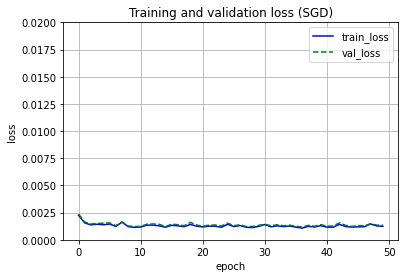

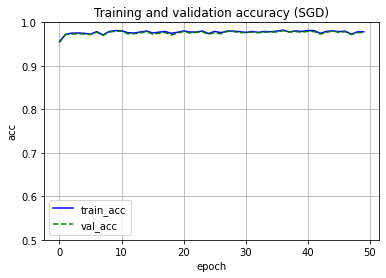

In [ ]:
# plot graph
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.ylim([0.0,0.02])
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss (SGD)')
plt.grid()
plt.savefig('CNN_FashionMNIST_SGD_loss.png')
plt.show()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.ylim([0.5, 1.0])
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy (SGD)')
plt.grid()
plt.savefig('CNN_FashionMNIST_SGD_acc.png')
plt.show()